In [1]:
import os
from datetime import timedelta

import fsspec
import xarray as xr
from dask.diagnostics import ProgressBar
from vcm.fv3.metadata import gfdl_to_standard

In [2]:
NUDGED_RUN_URL = 'gs://vcm-ml-experiments/default/2022-01-27/n2f-prescribe-t-nudge-apparent-sources-only-long/fv3gfs_run'
FINE_RES_BUDGET_URL = 'gs://vcm-ml-experiments/default/2021-12-16/2020-05-27-40-day-X-SHiELD-simulation-v2/fine-res-budget.zarr'
OUTPUT_URL = 'gs://vcm-ml-intermediate/2023-01-09/prescribed-radiative-fluxes-for-training-rad-flux-model.zarr'
VARIABLES = [
    'air_temperature', 'specific_humidity', 'pressure_thickness_of_atmospheric_layer',
    'DSWRFsfc_coarse', 'DLWRFsfc_coarse', 'DSWRFtoa_coarse', 'USWRFsfc_coarse',
    'surface_diffused_shortwave_albedo', 'surface_geopotential', 'land_sea_mask'
]

RENAME = {
    'DSWRFsfc_coarse': 'override_for_time_adjusted_total_sky_downward_shortwave_flux_at_surface',
    'DLWRFsfc_coarse': 'override_for_time_adjusted_total_sky_downward_longwave_flux_at_surface',
    'DSWRFtoa_coarse': 'total_sky_downward_shortwave_flux_at_top_of_atmosphere',
}

def net_shortwave(ds: xr.Dataset) -> xr.DataArray:
    net_shortwave = ds["DSWRFsfc_coarse"] - ds["USWRFsfc_coarse"]
    net_shortwave = net_shortwave.assign_attrs(
        {
            "long_name": "net shortwave radiative flux at surface",
            "units": "W/m^2",
        }
    )
    return net_shortwave

def transmissivity(ds):
    transmissivity = xr.where(
        ds['DSWRFtoa_coarse'] > 0.,
        ds['DSWRFsfc_coarse'] / ds['DSWRFtoa_coarse'],
        0.
    )
    transmissivity = transmissivity.assign_attrs(
        {
            "long_name": "downward transmissivity of atmospheric column to shortwave",
            "units": "unitless",
        }
    )
    return transmissivity

In [3]:
state = xr.open_zarr(os.path.join(NUDGED_RUN_URL, 'state_after_timestep.zarr'))
state = state[['surface_diffused_shortwave_albedo', 'surface_geopotential', 'land_sea_mask']]

fine_res = gfdl_to_standard(xr.open_zarr(FINE_RES_BUDGET_URL)).drop('tile')
fine_res = fine_res.rename(T='air_temperature', sphum='specific_humidity', delp='pressure_thickness_of_atmospheric_layer')
fine_res = fine_res[
    ['air_temperature', 'specific_humidity', 'pressure_thickness_of_atmospheric_layer', 
     'DSWRFsfc_coarse', 'DLWRFsfc_coarse', 'DSWRFtoa_coarse', 'USWRFsfc_coarse'
    ]
]
fine_res['time'] = fine_res.time + timedelta(minutes=7, seconds=30)

ds = xr.merge([state, fine_res], join='inner')

ds = ds[VARIABLES]
ds['override_for_time_adjusted_total_sky_net_shortwave_flux_at_surface'] = net_shortwave(ds)
ds['shortwave_transmissivity_of_atmospheric_column'] = transmissivity(ds)
ds = ds.rename(RENAME)
ds = ds.drop_vars('USWRFsfc_coarse')
ds = ds.chunk({'time': 8})
for k in ds:
    ds[k].encoding = {}

/home/OliWM/miniconda3/envs/fv3net/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


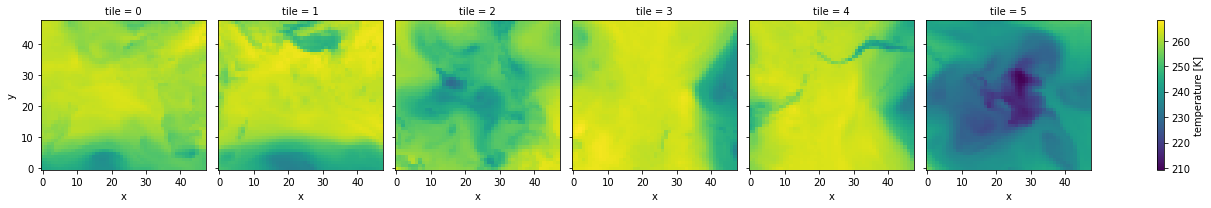

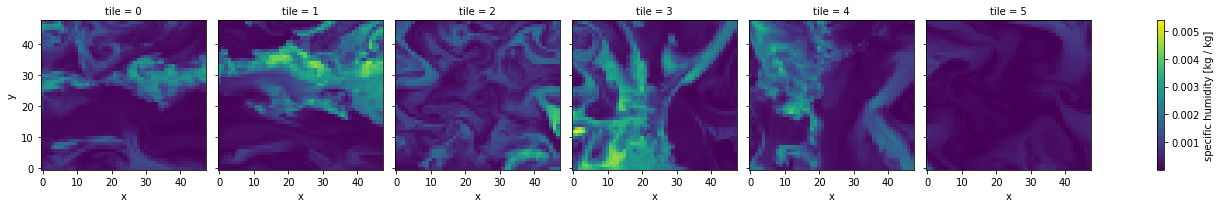

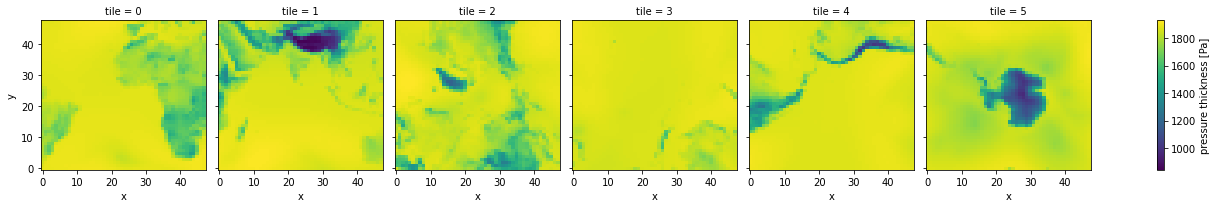

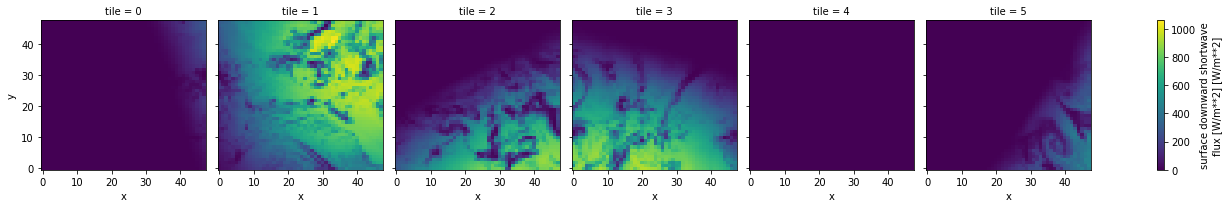

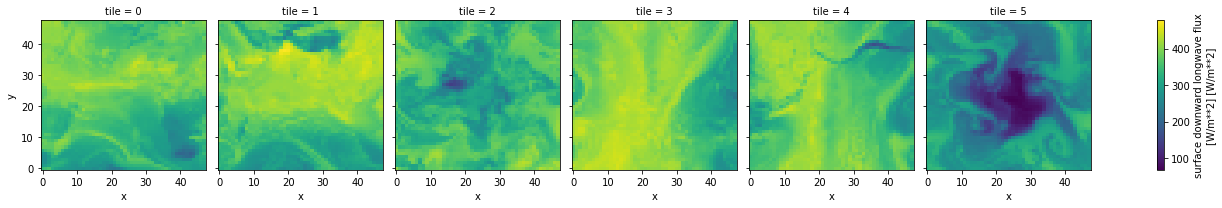

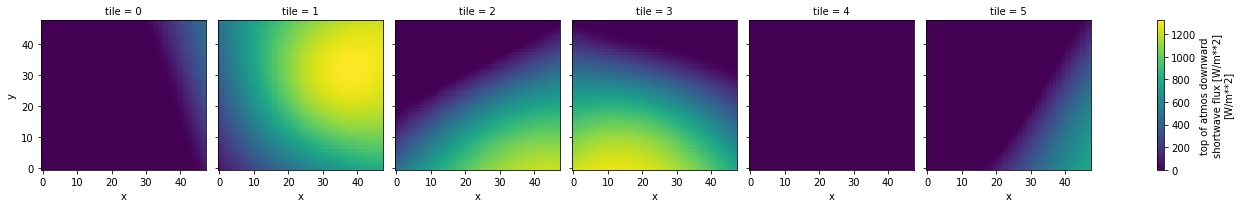

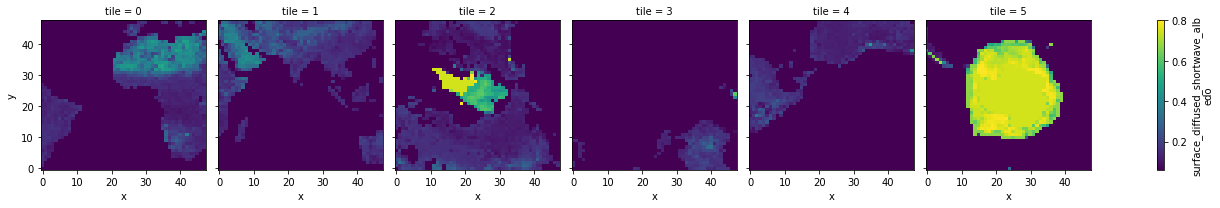

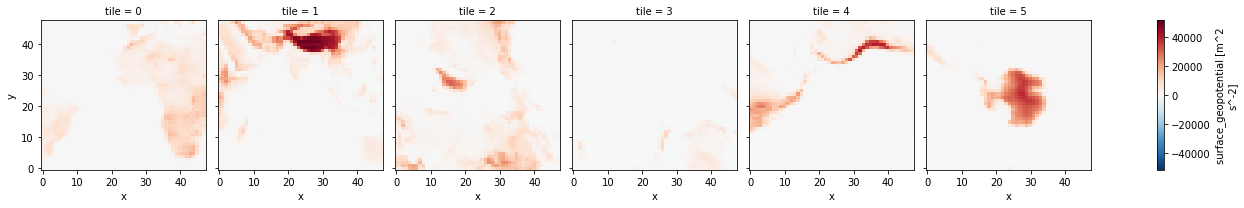

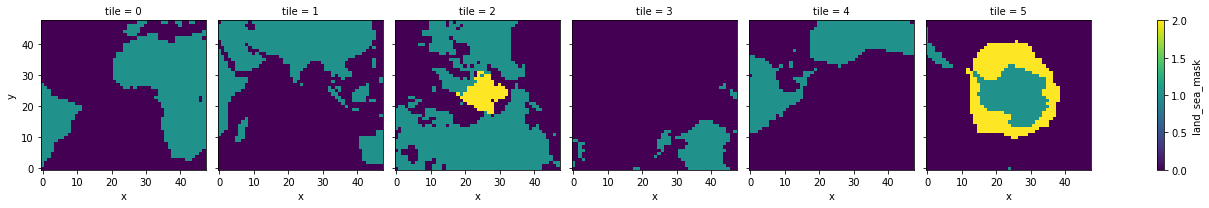

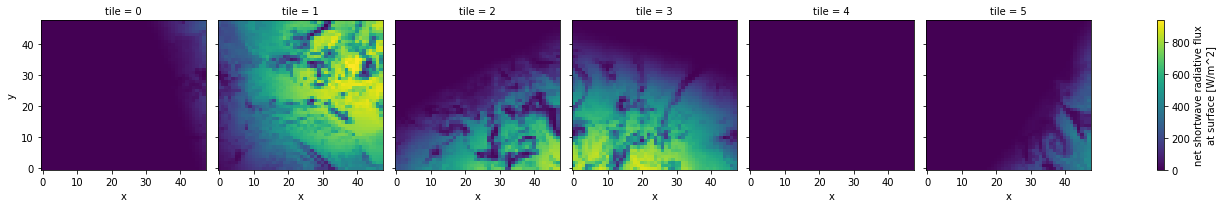

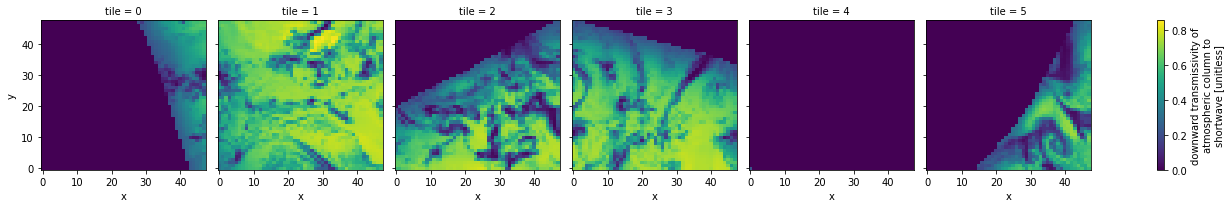

In [4]:
for variable in ds:
    da = ds[variable]
    if 'z' in da.dims:
        da = da.isel(z=40)
    da.isel(time=100).plot(col='tile')

In [5]:
m = fsspec.get_mapper(OUTPUT_URL)

with ProgressBar():
    ds.to_zarr(m, consolidated=True, mode='w')

[########################################] | 100% Completed | 10m 44s
